<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>

### Импорт библиотек

In [ ]:
# Установим недостающие библиотеки
!pip install torchinfo
!pip install googledrivedownloader

In [1]:
import os
import copy
import torch
import random
import pickle
import numpy as np
from time import time
import torch.nn as nn
from matplotlib import cm
from torchvision import ops
import torch.optim as optim
from torchinfo import summary
from skimage.io import imread
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib import rcParams
from torch.autograd import Variable
from skimage.transform import resize
from torch.utils.data import DataLoader
from IPython.display import clear_output
from torchvision import models, transforms
from google_drive_downloader import GoogleDriveDownloader as gdd

rcParams['figure.figsize'] = (15, 4)

### Зафиксируем random

In [2]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>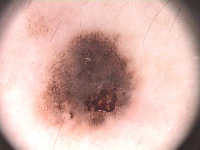</td><td>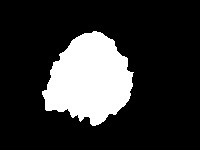</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
gdd.download_file_from_google_drive(file_id='1VtEDXKLJSe0-x3RnQvlvZZv9bqKMte0h',
                                    dest_path='./PH2Dataset.rar',
                                    unzip=False)

In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [3]:
images = []
lesions = []

root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

In [4]:
print(f'Изображений для сегментации - {len(images)} штук, изображений с результатами - {len(lesions)} штук')

Изображений для сегментации - 200 штук, изображений с результатами - 200 штук


Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [5]:
size = (256, 256)

X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [6]:
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

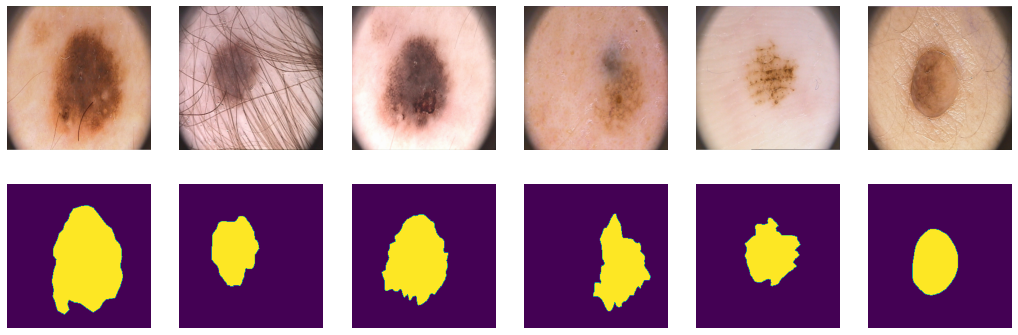

In [7]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [8]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [9]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [10]:
batch_size = 10

data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=False)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=False)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [12]:
if device.type == 'cuda':
    !nvidia-smi

Tue Nov 30 20:38:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.49       Driver Version: 496.49       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:07:00.0  On |                  N/A |
| 35%   42C    P8    11W / 160W |    644MiB /  6144MiB |      7%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet

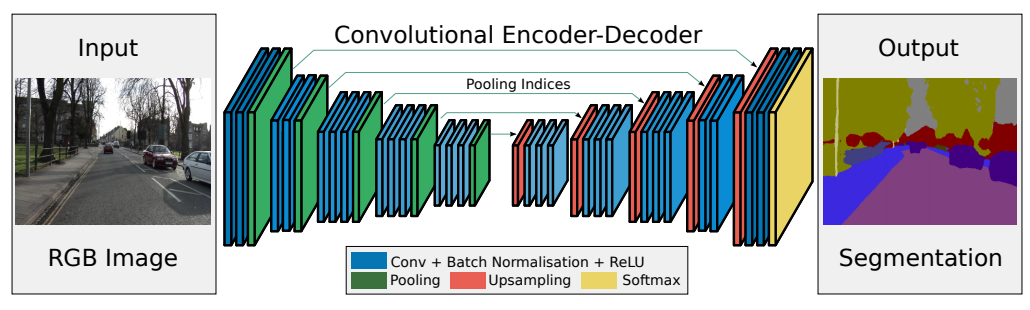

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [13]:
class SegNet(nn.Module):
    def __init__(self, inp_ch: int):
        super().__init__()
        """
        inp_ch - число фильтров в первом
        свёрточном слое
        """
        
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=inp_ch, kernel_size=3, padding=1),           
            nn.BatchNorm2d(inp_ch),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch, out_channels=inp_ch, kernel_size=3, padding=1),           
            nn.BatchNorm2d(inp_ch),
            nn.ReLU()
        )
        
        self.pool0 = nn.MaxPool2d(kernel_size=2, return_indices=True)  # 256 -> 128
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch, out_channels=inp_ch*2, kernel_size=3, padding=1),            
            nn.BatchNorm2d(inp_ch*2),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*2, out_channels=inp_ch*2, kernel_size=3, padding=1),            
            nn.BatchNorm2d(inp_ch*2),
            nn.ReLU()
        )
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, return_indices=True)  # 128 -> 64
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch*2, out_channels=inp_ch*4, kernel_size=3, padding=1),            
            nn.BatchNorm2d(inp_ch*4),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*4, out_channels=inp_ch*4, kernel_size=3, padding=1),           
            nn.BatchNorm2d(inp_ch*4),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*4, out_channels=inp_ch*4, kernel_size=3, padding=1),            
            nn.BatchNorm2d(inp_ch*4),
            nn.ReLU()
        )
        
        self.pool2 = nn.MaxPool2d(kernel_size=2, return_indices=True)  # 64 -> 32
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch*4, out_channels=inp_ch*8, kernel_size=3, padding=1),        
            nn.BatchNorm2d(inp_ch*8),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*8, out_channels=inp_ch*8, kernel_size=3, padding=1),            
            nn.BatchNorm2d(inp_ch*8),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*8, out_channels=inp_ch*8, kernel_size=3, padding=1),           
            nn.BatchNorm2d(inp_ch*8),
            nn.ReLU()
        )
        
        self.pool3 = nn.MaxPool2d(kernel_size=2, return_indices=True)  # 32 -> 16
          
        self.bottleneck_enc = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch*8, out_channels=inp_ch*16, kernel_size=3, padding=1),           
            nn.BatchNorm2d(inp_ch*16),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*16, out_channels=inp_ch*16, kernel_size=3, padding=1),            
            nn.BatchNorm2d(inp_ch*16),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*16, out_channels=inp_ch*16, kernel_size=3, padding=1),            
            nn.BatchNorm2d(inp_ch*16),
            nn.ReLU()
        )
        
        self.bottleneck_pool = nn.MaxPool2d(kernel_size=2, return_indices=True)
        
        self.bottleneck_upsample = nn.MaxUnpool2d(kernel_size=2)
        
        self.bottleneck_dec = nn.Sequential(          
            nn.Conv2d(in_channels=inp_ch*16, out_channels=inp_ch*16, kernel_size=3, padding=1),            
            nn.BatchNorm2d(inp_ch*16),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*16, out_channels=inp_ch*16, kernel_size=3, padding=1),            
            nn.BatchNorm2d(inp_ch*16),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*16, out_channels=inp_ch*8, kernel_size=3, padding=1),           
            nn.BatchNorm2d(inp_ch*8),
            nn.ReLU()
        )
             
        # Decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2)  # 16 -> 32
        
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch*8, out_channels=inp_ch*8, kernel_size=3, padding=1),            
            nn.BatchNorm2d(inp_ch*8),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*8, out_channels=inp_ch*8, kernel_size=3, padding=1),          
            nn.BatchNorm2d(inp_ch*8),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*8, out_channels=inp_ch*4, kernel_size=3, padding=1),            
            nn.BatchNorm2d(inp_ch*4),
            nn.ReLU()
        )       
        
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2)  # 32 -> 64
        
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch*4, out_channels=inp_ch*4, kernel_size=3, padding=1),            
            nn.BatchNorm2d(inp_ch*4),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*4, out_channels=inp_ch*4, kernel_size=3, padding=1),           
            nn.BatchNorm2d(inp_ch*4),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*4, out_channels=inp_ch*2, kernel_size=3, padding=1),           
            nn.BatchNorm2d(inp_ch*2),
            nn.ReLU()
        )
        
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2)  # 64 -> 128
        
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch*2, out_channels=inp_ch*2, kernel_size=3, padding=1),            
            nn.BatchNorm2d(inp_ch*2),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*2, out_channels=inp_ch, kernel_size=3, padding=1),           
            nn.BatchNorm2d(inp_ch),
            nn.ReLU()
        )

        self.upsample3 = nn.MaxUnpool2d(kernel_size=2)  # 128 -> 256
        
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch, out_channels=inp_ch, kernel_size=3, padding=1),            
            nn.BatchNorm2d(inp_ch),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch, out_channels=1, kernel_size=3, padding=1),
        )
        
                
    def forward(self, x):
        # Encoder
        e0 = self.enc_conv0(x)
        e0, ind0 = self.pool0(e0)
        e1 = self.enc_conv1(e0)
        e1, ind1 = self.pool1(e1)
        e2 = self.enc_conv2(e1)
        e2, ind2 = self.pool2(e2)
        e3 = self.enc_conv3(e2)
        e3, ind3 = self.pool3(e3)

        # Bottleneck
        b = self.bottleneck_enc(e3)
        b, ind_b = self.bottleneck_pool(b)
        b = self.bottleneck_upsample(b, ind_b)
        b = self.bottleneck_dec(b)

        # Decoder
        d0 = self.upsample0(b, ind3)
        d0 = self.dec_conv0(d0)
        d1 = self.upsample1(d0, ind2)
        d1 = self.dec_conv1(d1)        
        d2 = self.upsample2(d1, ind1)
        d2 = self.dec_conv2(d2)           
        d3 = self.upsample3(d2, ind0)
        d3 = self.dec_conv3(d3) # No activation  
        return d3

In [14]:
summary(SegNet(32).to('cpu'), (1, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
SegNet                                   --                        --
├─Sequential: 1-1                        [1, 32, 256, 256]         --
│    └─Conv2d: 2-1                       [1, 32, 256, 256]         896
│    └─BatchNorm2d: 2-2                  [1, 32, 256, 256]         64
│    └─ReLU: 2-3                         [1, 32, 256, 256]         --
│    └─Conv2d: 2-4                       [1, 32, 256, 256]         9,248
│    └─BatchNorm2d: 2-5                  [1, 32, 256, 256]         64
│    └─ReLU: 2-6                         [1, 32, 256, 256]         --
├─MaxPool2d: 1-2                         [1, 32, 128, 128]         --
├─Sequential: 1-3                        [1, 64, 128, 128]         --
│    └─Conv2d: 2-7                       [1, 64, 128, 128]         18,496
│    └─BatchNorm2d: 2-8                  [1, 64, 128, 128]         128
│    └─ReLU: 2-9                         [1, 64, 128, 128]         --
│    └

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [15]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    return iou 

## Функция потерь 

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [16]:
def bce_loss(y_pred, y_real):
    # TODO 
    # please don't use nn.BCELoss. write it from scratch
    BCEloss = (torch.maximum(y_pred, torch.zeros_like(y_pred)) - y_pred*y_real + torch.log(1 + torch.exp(-torch.abs(y_pred)))).mean((1,2,3)).mean()
    return BCEloss

Протестируем работу лоса в сравнении с библиотечной реализацией

In [17]:
yp = torch.randn(16, 3, 256, 256)
yr = torch.randn(16, 3, 256, 256)

print(nn.BCEWithLogitsLoss()(yp, yr), bce_loss(yp, yr))

tensor(0.8057) tensor(0.8057)


## Тренировка 

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [18]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, is_scheduler=True, agm=True):
    """ Функция обучения и валидации

    Args:
        model - модель
        opt - оптимизатор
        loss_fn - функция потерь
        epochs - количество эпох
        data_tr - трэйн-сет
        data_val - валидационный сет
        is_scheduler - scheduler, если используется. По-умолчанию True
        agm - augmentation, если используется. По-умолчанию True.

    Returns:
        history: {
               epoch: номер эпохи
               train_loss: значение функции потерь на трэйн-сете
               val_loss: значения функции потерь на валидационном сете
               train_score: значение метрики на трэйн-сете
               val_score: значение метрики на валидационном сете
              }
    """
    X_val, Y_val = next(iter(data_val))
    history = {"epochs": np.arange(epochs)+1, "train": {"score":[], "loss":[]}, "val": {"score":[], "loss":[]}}
    
    if is_scheduler:
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer=opt, gamma=0.95)
       
    # Set default parameters for saving model weights
    best_model_weights = model.state_dict()
    best_score_val = 0.0
    
    # Augmentations
    transforms_train = transforms.Compose([
        transforms.RandomHorizontalFlip(p=1),
        transforms.RandomAdjustSharpness(.9, p=0.5),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.7, contrast=0.7, saturation=0.7)], p=0.5),
        transforms.RandomApply([transforms.Grayscale(3),], p=0.5)
    ])
        
    transforms_test = transforms.Compose([
        transforms.RandomHorizontalFlip(p=1)
    ])
    
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))
        
        avg_loss = 0
        avg_loss = 0
        avg_score = 0
        avg_loss_val = 0
        avg_score_val = 0
        
        model.train()  # Train mode
        for X_batch, Y_batch in data_tr:
            # Data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            if agm:
                if random.random() > 0.6:  # Bероятность применения аугментций
                    X_batch = transforms_train(X_batch)
                    Y_batch = transforms_test(Y_batch)              
            # Set parameter gradients to zero
            opt.zero_grad()
            # Forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch) # Forward-pass
            loss.backward()  # Backward-pass
            opt.step()  # Update weights
            score = iou_pytorch(torch.sigmoid(Y_pred) > 0.5, Y_batch).mean().item() # Make score

            # Calculate loss to show the user
            avg_loss += loss / len(data_tr)
            avg_score += score / len(data_tr)
            
        toc = time()
        print('loss: %f' % avg_loss)
        if is_scheduler:
            scheduler.step()

        # Show intermediate results
        model.eval()  # Testing mode
        Y_hat = model(X_val.to(device)).detach().to('cpu') # Detach and put into cpu

        # Visualize tools
        clear_output(wait=True)
        
        # Validation
        with torch.no_grad():
            for X_val_batch, Y_val_batch in data_val:
                X_val_batch = X_val_batch.to(device)
                Y_val_batch = Y_val_batch.to(device)
                Y_pred_val = model(X_val_batch)
                loss_val = loss_fn(Y_pred_val, Y_val_batch)
                score_val = iou_pytorch(torch.sigmoid(Y_pred_val) > 0.5, Y_val_batch)
                avg_loss_val += loss / len(data_val)
                avg_score_val += score_val.mean() / len(data_val)
        
        # Save best model weights
        if avg_score_val.cpu().item() > best_score_val:
            best_score_val = avg_score_val
            best_model_weights = copy.deepcopy(model.state_dict())
        
        # Adding to history
        history["train"]["score"].append(avg_score)
        history["val"]["score"].append(avg_score_val.item())
        history["train"]["loss"].append(avg_loss.item())
        history["val"]["loss"].append(avg_loss_val.item())
        
        # Visualisations
        fig, ax = plt.subplots(3, 6, figsize=(12, 10))
        for k in range(6):
            ax[0, k].imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            ax[0, k].set_title("Real")
            ax[0, k].axis('off')
            ax[1, k].imshow(torch.sigmoid(Y_hat[k, 0]) > 0.5, cmap='gray')
            ax[1, k].set_title("Output")
            ax[1, k].axis('off') 
            ax[2, k].imshow(Y_val[k, 0], cmap='gray')
            ax[2, k].set_title("Ground Truth")
            ax[2, k].axis('off')                    
        plt.suptitle('%d / %d - train_loss: %f, val_loss: %f, train_score: %f, val_score: %f' % (epoch+1, epochs, avg_loss, avg_loss_val, avg_score, avg_score_val))
        plt.tight_layout()
        plt.show() 

    # Delete cache
    X_batch.to('cpu')
    del X_batch
    Y_batch.to('cpu')
    del Y_batch
    X_val_batch.to('cpu')
    del X_val_batch
    Y_val_batch.to('cpu')
    del Y_val_batch
    
    # load best model weights
    model.load_state_dict(best_model_weights)
    torch.cuda.empty_cache()
    
    return history

## Инференс

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [19]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [X_batch for X_batch, _ in data]
    return np.array(Y_pred)

Функция вычисления метрики

In [20]:
def score_model(model, metric, data):
    model.eval()  # Testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = torch.sigmoid(model(X_batch.to(device))) > 0.5
        scores += metric(Y_pred, Y_label.to(device)).mean().item()
    
    # Delete cache
    X_batch.to('cpu')
    del X_batch
    Y_label.to('cpu')
    del Y_label

    return scores/len(data)

Функция для отрисовки графиков score и loss по всем эпохам

In [21]:
def make_graph(history, model_name, loss_name):
    '''function to visualize score and loss plots throw epochs'''
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    x = history["epochs"]
    loss_train = history["train"]["loss"]
    loss_val = history["val"]["loss"]
    score_train = history["train"]["score"]
    score_val = history["val"]["score"]
    
    ax[0].plot(x, loss_train, label="train", color="blue")
    ax[0].plot(x, loss_val, label="val", color="orange")
    ax[0].legend(fontsize=14)
    ax[0].grid(linestyle="--")
    ax[0].tick_params(labelsize=14)
    ax[0].set_xlabel("epoch", fontsize=14)
    ax[0].set_ylabel("loss", fontsize=14)
    ax[0].set_title("Loss vs epoch", fontsize=16)
    ax[0].set_xlim(left=0, right=x.max())
    ax[0].set_ylim(bottom=0)
    ax[1].plot(x, score_train, label="train", color="blue")
    ax[1].plot(x, score_val, label="val", color="orange")
    ax[1].legend(fontsize=14)
    ax[1].grid(linestyle="--")
    ax[1].tick_params(labelsize=14)
    ax[1].set_xlabel("epoch", fontsize=14)
    ax[1].set_ylabel("score", fontsize=14)
    ax[1].set_title("Score vs epoch", fontsize=16)
    ax[1].set_xlim(left=0, right=x.max())
    ax[1].set_ylim(bottom=0)
    plt.suptitle(f"Model = {model_name}, loss = {loss_name}", fontsize=16)
    plt.tight_layout()
    plt.show()

Функция вычисляет score на валидации и тесте для обученной модели

In [22]:
def scores(model):
    val_score = score_model(model, iou_pytorch, data_val)
    test_score = score_model(model, iou_pytorch, data_ts)
    print(f"Score на валидации: {val_score:.4f}, score на тесте: {test_score:.4f}")
    return val_score, test_score

### Вспомогательные функции

In [23]:
# Очистка памяти после обучения модели
def clear_cache(model):
    model.to("cpu")
    del model
    torch.cuda.empty_cache()

In [24]:
# Сохранение результатов обучения модели
def save_results(history:dict, model_name:str):
    with open(f'./{model_name}.pkl', 'wb') as f:
        pickle.dump(history, f)

In [25]:
# Загрузка результатов обучения модели
def load_results(model_name:str):
    with open(f'./{model_name}.pkl', 'rb') as f:
        return pickle.load(f)

## Основной момент: обучение

### 1.1 SegNet с BCE loss без агументаций

Проведём обучение модели Segnet c лоссом "BCE" без применения аугментаций:

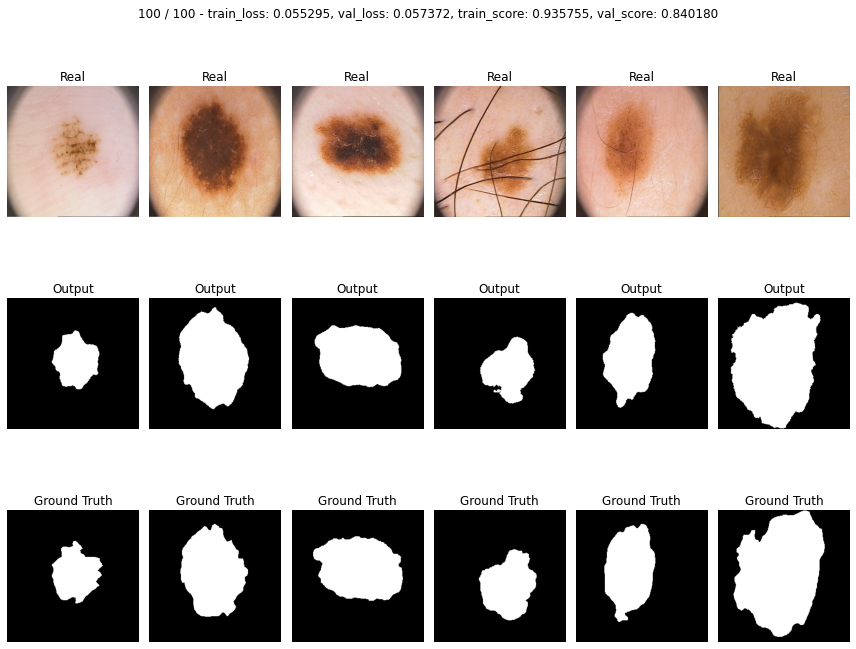

In [26]:
# Параметры оптимизатора и learning rate определены как оптимальные после множества экспериментов
# и используются в дальнейшей работе при обучении всех моделей
model_segnet_bce_wo_agm = SegNet(32).to(device)

max_epochs = 100
opt = optim.Adam(model_segnet_bce_wo_agm.parameters(), lr=3e-4, amsgrad=True)
segnet_bce_wo_agm = train(model_segnet_bce_wo_agm, opt, bce_loss, max_epochs, data_tr, data_val, agm=False)

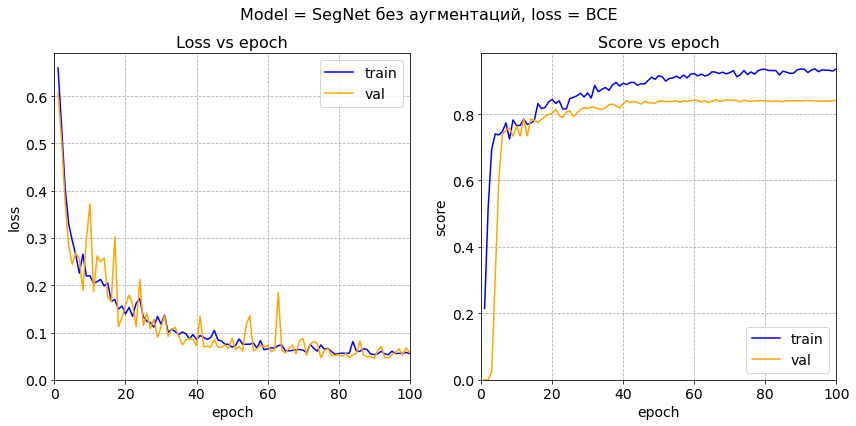

In [27]:
make_graph(segnet_bce_wo_agm, "SegNet без аугментаций" , "BCE")

In [28]:
segnet_bce_wo_agm_val_score, segnet_bce_wo_agm_test_score = scores(model_segnet_bce_wo_agm)

Score на валидации: 0.8430, score на тесте: 0.8424


In [29]:
# Очистка кеша
clear_cache(model_segnet_bce_wo_agm)

### 1.2 SegNet с BCE loss 

Обучим эту же модель, но с применением аугментаций

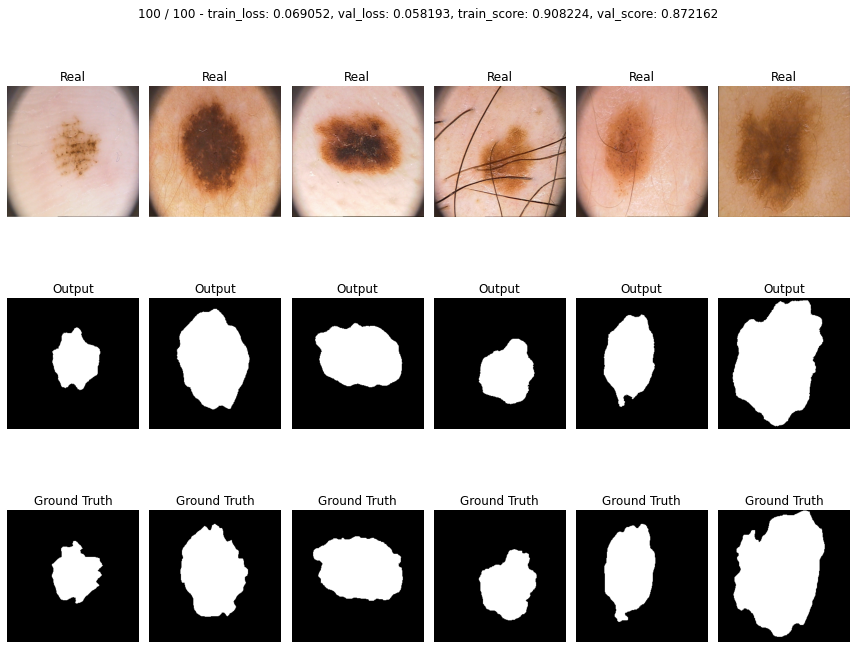

In [30]:
model_segnet_bce = SegNet(32).to(device)

max_epochs = 100
opt = optim.Adam(model_segnet_bce.parameters(), lr=3e-4, amsgrad=True)
segnet_bce = train(model_segnet_bce, opt, bce_loss, max_epochs, data_tr, data_val, agm=True)

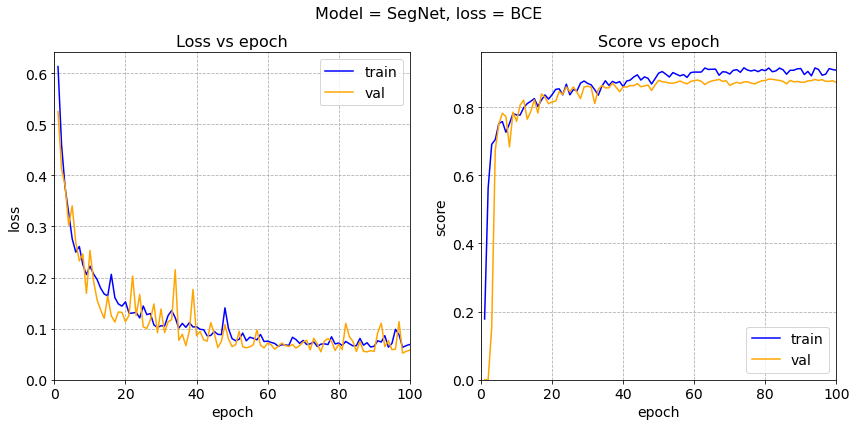

In [31]:
make_graph(segnet_bce, "SegNet", "BCE")

In [32]:
segnet_bce_val_score, segnet_bce_test_score = scores(model_segnet_bce)

Score на валидации: 0.8822, score на тесте: 0.8748


In [33]:
# Очистка кеша
clear_cache(model_segnet_bce)

In [34]:
# Сохраним результаты обучения
save_results(segnet_bce, 'model_segnet_bce')

*Исходя из графиков обучения, можно сделать вывод, что без применения аугментаций наблюдаются признаки переобучения. Они не так сильны, но всё же расхождение графиков (score vs epoch) заметно уже после 30-ой эпохи. Благодаря аугментации, расхождение начинается только около 60-ой эпохи и не является столь значительным. Кроме того, применение агументаций позволило повысить обобщающую способность сети, тем самым увеличить скор на тесте. В дальнейшем, все последующие модели будем обучать с применением аугментаций.*

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [35]:
def dice_loss(y_pred, y_real):
    smooth = 1.  # Константа для избежания ситуации деления на нуль (наиболее популярная реализация)
    y_pred = torch.sigmoid(y_pred)
    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)
    num = (2 * (y_pred * y_real).sum() + smooth)
    den = (y_pred.sum() + y_real.sum() + smooth)
    res = 1 - (num/den).mean()  # Усредняем по батчу
    return res 

### 1.3 SegNet с Dice loss 

Проводим тестирование:

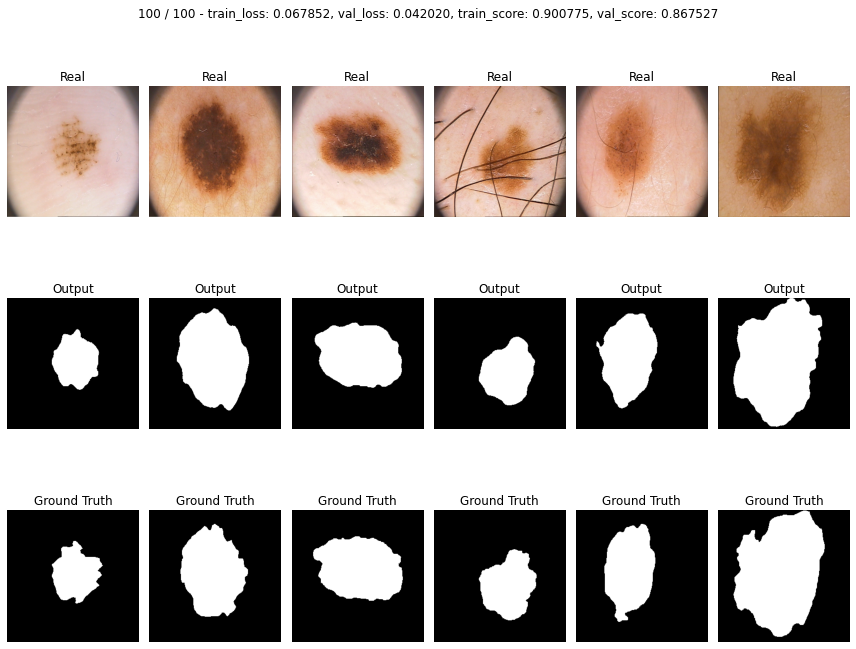

In [36]:
model_segnet_dice = SegNet(32).to(device)

max_epochs = 100
opt = optim.Adam(model_segnet_dice.parameters(), lr=3e-4, amsgrad=True)
segnet_dice = train(model_segnet_dice, opt, dice_loss, max_epochs, data_tr, data_val, agm=True)

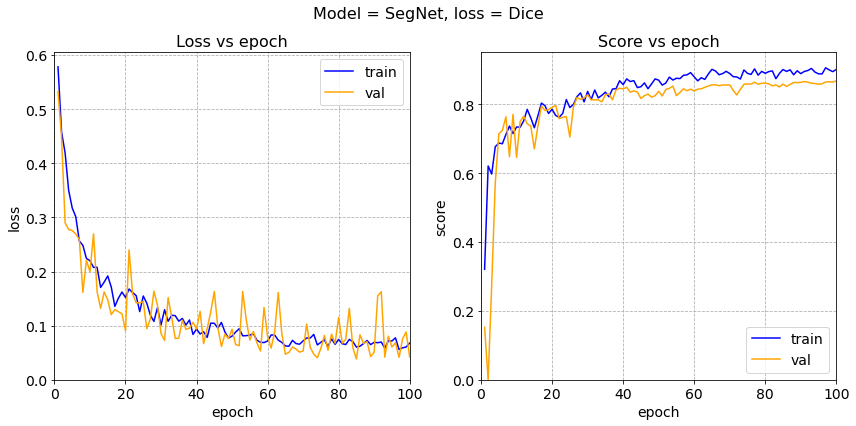

In [37]:
make_graph(segnet_dice, "SegNet", "Dice")

In [38]:
segnet_dice_val_score, segnet_dice_test_score = scores(model_segnet_dice)

Score на валидации: 0.8675, score на тесте: 0.8580


In [39]:
# Очистка кеша
clear_cache(model_segnet_dice)

In [40]:
# Сохраним результаты обучения
save_results(segnet_dice, 'model_segnet_dice')

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [41]:
# В качестве ce_loss возмем стабильную реализацию BCE loss написанную выше
def focal_loss(y_pred, y_real, eps=-1, gamma=2):
    p = torch.sigmoid(y_pred)
    ce_loss = torch.maximum(y_pred, torch.zeros_like(y_pred)) - y_pred*y_real + torch.log(1 + torch.exp(-torch.abs(y_pred)))
    p_t = p*y_real + (1 - p)*(1 - y_real)
    loss = ce_loss*((1 - p_t)**gamma)
    if eps >= 0:
        alpha_t = eps*y_real + (1 - eps)*(1 - y_real)
        loss = alpha_t*loss
    loss = loss.mean((1,2,3)).mean()  # Усредняем по батчу
    return loss

Протестируем работу лоса в сравнении с библиотечной реализацией

In [42]:
print(ops.sigmoid_focal_loss(yp, yr, gamma=2, alpha=-1, reduction='mean'), focal_loss(yp, yr))

tensor(0.9232) tensor(0.9232)


### 1.4 SegNet с Focal loss 

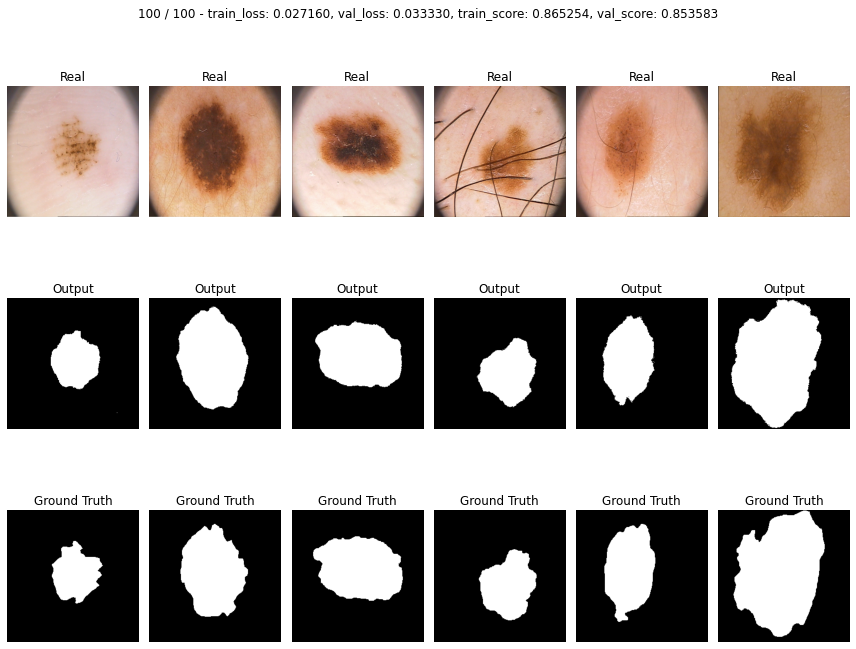

In [43]:
model_segnet_focal = SegNet(32).to(device)

max_epochs = 100
opt = optim.Adam(model_segnet_focal.parameters(), lr=3e-4, amsgrad=True)
segnet_focal = train(model_segnet_focal, opt, focal_loss, max_epochs, data_tr, data_val, agm=True)

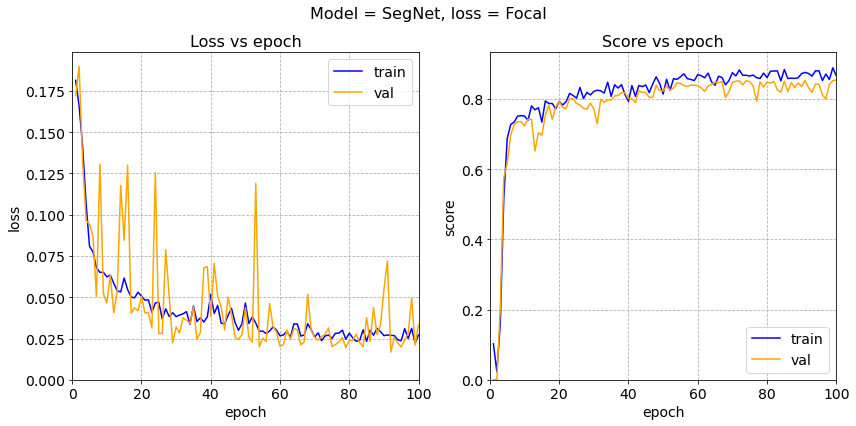

In [44]:
make_graph(segnet_focal, "SegNet", "Focal")

In [45]:
segnet_focal_val_score, segnet_focal_test_score = scores(model_segnet_focal)

Score на валидации: 0.8536, score на тесте: 0.8436


In [46]:
# Очистка кеша
clear_cache(model_segnet_focal)

In [47]:
# Сохраним результаты обучения
save_results(segnet_focal, 'model_segnet_focal')

----------------------------------------------------------------------------------------------

## Мир сегментационных лоссов 

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме того провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многоклассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

In [48]:
# Lovasz Softmax loss
# За основу вязта работа https://github.com/bermanmaxim/LovaszSoftmax/blob/master/pytorch/lovasz_losses.py

# Вычисляем градиент вектора ошибок
def lovasz_grad(gt_sorted):
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1: # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard

def lovasz_loss(logits, labels):
    labels = labels.view(-1)
    logits = logits.view(-1)
    
    if len(labels) == 0:
        # only void pixels, the gradients should be 0
        return logits.sum() * 0.
    
    signs = 2. * labels.float() - 1.
    errors = (1. - logits * Variable(signs))
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.relu(errors_sorted), Variable(grad))
    return loss

### 1.5 SegNet с Lovasz Softmax loss

In [109]:
model_segnet_lovasz = SegNet(32).to(device)

max_epochs = 100
opt = optim.Adam(model_segnet_lovasz.parameters(), lr=3e-4, amsgrad=True)
segnet_lovasz = train(model_segnet_lovasz, opt, lovasz_loss, max_epochs, data_tr, data_val, agm=True)

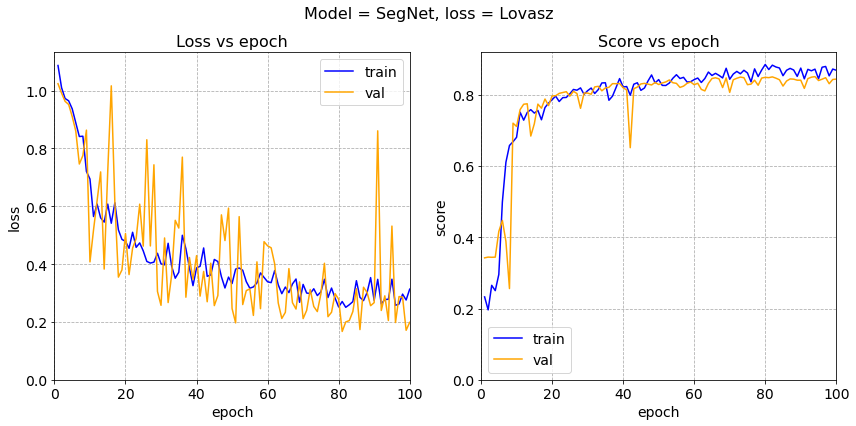

In [110]:
make_graph(segnet_lovasz, "SegNet", "Lovasz")

In [111]:
segnet_lovasz_val_score, segnet_lovasz_test_score = scores(model_segnet_lovasz)

Score на валидации: 0.8505, score на тесте: 0.8546


In [112]:
# Очистка кеша
clear_cache(model_segnet_lovasz)

In [113]:
# Сохраним результаты обучения
save_results(segnet_lovasz, 'model_segnet_lovasz')

-----------------------------------------------------------------------------------------

# U-Net

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

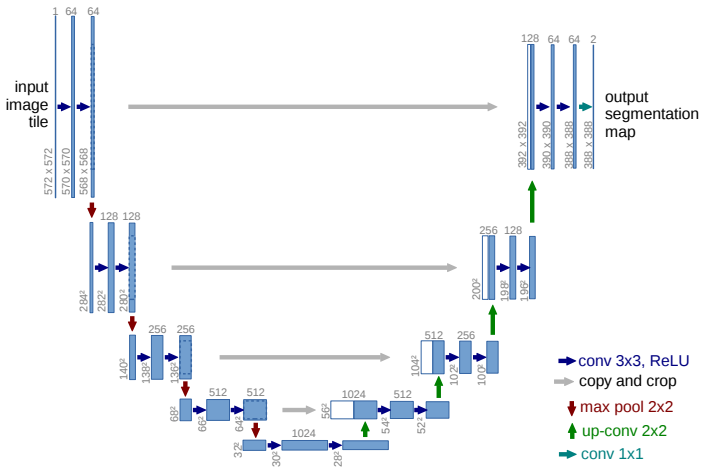

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [54]:
class UNet(nn.Module):
    def __init__(self, inp_ch:int):
        super().__init__()        
        """
        inp_ch - число фильтров в первом
        свёрточном слое
        """

        # Encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=inp_ch, kernel_size=3, padding=1),           
            nn.BatchNorm2d(inp_ch),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch, out_channels=inp_ch, kernel_size=3, padding=1),           
            nn.BatchNorm2d(inp_ch),
            nn.ReLU()
        )
        
        self.pool0 = nn.MaxPool2d(kernel_size=2, return_indices=False)
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch, out_channels=inp_ch*2, kernel_size=3, padding=1),            
            nn.BatchNorm2d(inp_ch*2),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*2, out_channels=inp_ch*2, kernel_size=3, padding=1),            
            nn.BatchNorm2d(inp_ch*2),
            nn.ReLU()
        )
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, return_indices=False)
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch*2, out_channels=inp_ch*4, kernel_size=3, padding=1),            
            nn.BatchNorm2d(inp_ch*4),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*4, out_channels=inp_ch*4, kernel_size=3, padding=1),            
            nn.BatchNorm2d(inp_ch*4),
            nn.ReLU()
        )
        
        self.pool2 = nn.MaxPool2d(kernel_size=2, return_indices=False)
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch*4, out_channels=inp_ch*8, kernel_size=3, padding=1),        
            nn.BatchNorm2d(inp_ch*8),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*8, out_channels=inp_ch*8, kernel_size=3, padding=1),           
            nn.BatchNorm2d(inp_ch*8),
            nn.ReLU()
        )
        
        self.pool3 = nn.MaxPool2d(kernel_size=2, return_indices=False)   
          
        self.bottleneck_enc = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch*8, out_channels=inp_ch*16, kernel_size=3, padding=1),           
            nn.BatchNorm2d(inp_ch*16),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*16, out_channels=inp_ch*8, kernel_size=3, padding=1),            
            nn.BatchNorm2d(inp_ch*8),
            nn.ReLU()
        )        
                                        
        # Decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2)
        
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch*16, out_channels=inp_ch*8, kernel_size=3, padding=1),            
            nn.BatchNorm2d(inp_ch*8),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*8, out_channels=inp_ch*4, kernel_size=3, padding=1),            
            nn.BatchNorm2d(inp_ch*4),
            nn.ReLU()
        )       
        
        self.upsample1 = nn.Upsample(scale_factor=2)
        
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch*8, out_channels=inp_ch*4, kernel_size=3, padding=1),            
            nn.BatchNorm2d(inp_ch*4),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*4, out_channels=inp_ch*2, kernel_size=3, padding=1),           
            nn.BatchNorm2d(inp_ch*2),
            nn.ReLU()
        )
        
        self.upsample2 = nn.Upsample(scale_factor=2)
        
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch*4, out_channels=inp_ch*2, kernel_size=3, padding=1),            
            nn.BatchNorm2d(inp_ch*2),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*2, out_channels=inp_ch, kernel_size=3, padding=1),           
            nn.BatchNorm2d(inp_ch),
            nn.ReLU()
        )

        self.upsample3 = nn.Upsample(scale_factor=2) 
        
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch*2, out_channels=inp_ch, kernel_size=3, padding=1),            
            nn.BatchNorm2d(inp_ch),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch, out_channels=inp_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch, out_channels=1, kernel_size=1)
        )
        
        
        
    def forward(self, x):
        # Encoder
        e0 = self.enc_conv0(x)
        e1 = self.pool0(e0)
        e2 = self.enc_conv1(e1)
        e3 = self.pool1(e2)
        e4 = self.enc_conv2(e3)
        e5 = self.pool2(e4)
        e6 = self.enc_conv3(e5)
        e7 = self.pool3(e6)

        # Bottleneck
        b = self.bottleneck_enc(e7)

        # Decoder
        d0 = self.upsample0(b)
        d0 = self.dec_conv0(torch.cat((d0,e6), dim=1))
        d1 = self.upsample1(d0)
        d1 = self.dec_conv1(torch.cat((d1,e4), dim=1))        
        d2 = self.upsample2(d1)
        d2 = self.dec_conv2(torch.cat((d2,e2), dim=1))           
        d3 = self.upsample3(d2)
        d3 = self.dec_conv3(torch.cat((d3,e0), dim=1))  
        return d3

In [55]:
summary(UNet(32).to('cpu'), (1, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     --                        --
├─Sequential: 1-1                        [1, 32, 256, 256]         --
│    └─Conv2d: 2-1                       [1, 32, 256, 256]         896
│    └─BatchNorm2d: 2-2                  [1, 32, 256, 256]         64
│    └─ReLU: 2-3                         [1, 32, 256, 256]         --
│    └─Conv2d: 2-4                       [1, 32, 256, 256]         9,248
│    └─BatchNorm2d: 2-5                  [1, 32, 256, 256]         64
│    └─ReLU: 2-6                         [1, 32, 256, 256]         --
├─MaxPool2d: 1-2                         [1, 32, 128, 128]         --
├─Sequential: 1-3                        [1, 64, 128, 128]         --
│    └─Conv2d: 2-7                       [1, 64, 128, 128]         18,496
│    └─BatchNorm2d: 2-8                  [1, 64, 128, 128]         128
│    └─ReLU: 2-9                         [1, 64, 128, 128]         --
│    └

### 2.1 U-Net с BCE loss

In [56]:
model_unet_bce = UNet(32).to(device)

max_epochs = 100
opt = optim.Adam(model_unet_bce.parameters(), lr=3e-4, amsgrad=True)
unet_bce = train(model_unet_bce, opt, bce_loss, max_epochs, data_tr, data_val, agm=True)

In [57]:
make_graph(unet_bce, "UNet", "BCE")

In [58]:
unet_bce_val_score, unet_bce_test_score = scores(model_unet_bce)

Score на валидации: 0.8808, score на тесте: 0.8805


In [59]:
# Очистка кеша
clear_cache(model_unet_bce)

In [60]:
# Сохраним результаты обучения
save_results(unet_bce, 'model_unet_bce')

### 2.2 U-Net с Dice loss

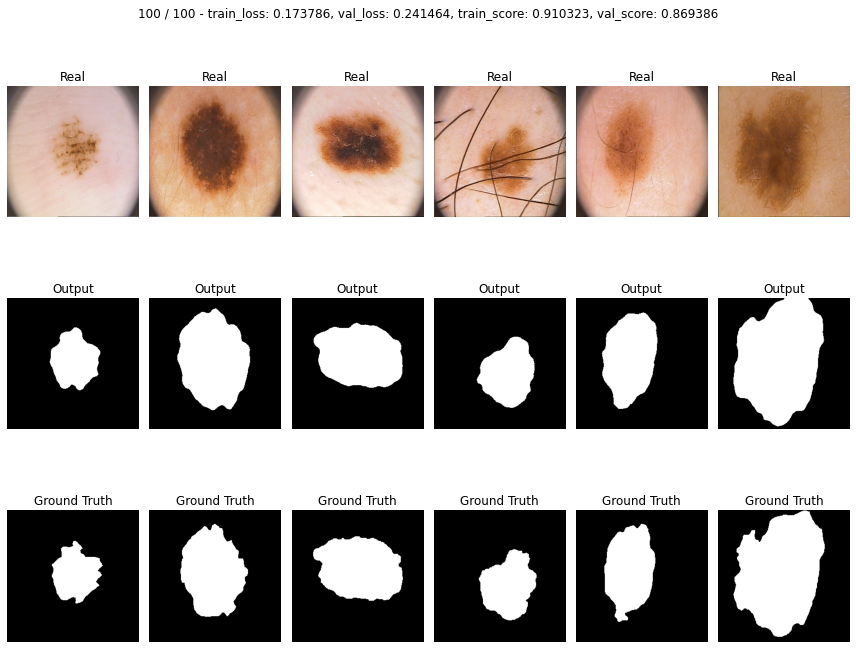

In [138]:
model_unet_dice = UNet(32).to(device)

max_epochs = 100
opt = optim.Adam(model_unet_dice.parameters(), lr=3e-4, amsgrad=True)
unet_dice = train(model_unet_dice, opt, dice_loss, max_epochs, data_tr, data_val, agm=True)

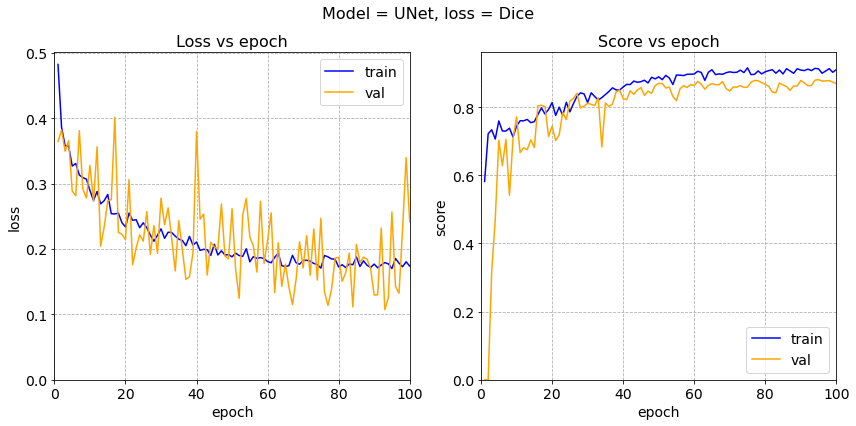

In [139]:
make_graph(unet_dice, "UNet", "Dice")

In [140]:
unet_dice_val_score, unet_dice_test_score = scores(model_unet_dice)

Score на валидации: 0.8809, score на тесте: 0.8687


In [141]:
# Очистка кеша
clear_cache(model_unet_dice)

In [142]:
# Сохраним результаты обучения
save_results(unet_dice, 'model_unet_dice')

### 2.3 U-Net с Focal loss

In [66]:
model_unet_focal = UNet(32).to(device)

max_epochs = 100
opt = optim.Adam(model_unet_focal.parameters(), lr=3e-4, amsgrad=True)
unet_focal = train(model_unet_focal, opt, focal_loss, max_epochs, data_tr, data_val, agm=True)

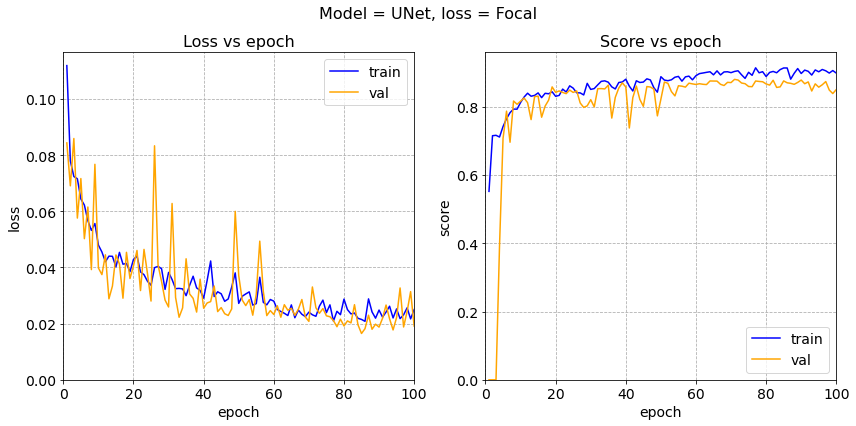

In [67]:
make_graph(unet_focal, "UNet", "Focal")

In [68]:
unet_focal_val_score, unet_focal_test_score = scores(model_unet_focal)

Score на валидации: 0.8802, score на тесте: 0.8636


In [69]:
# Очистка кеша
clear_cache(model_unet_focal)

In [70]:
# Сохраним результаты обучения
save_results(unet_focal, 'model_unet_focal')

### 2.4 U-Net с Lovasz Softmax loss

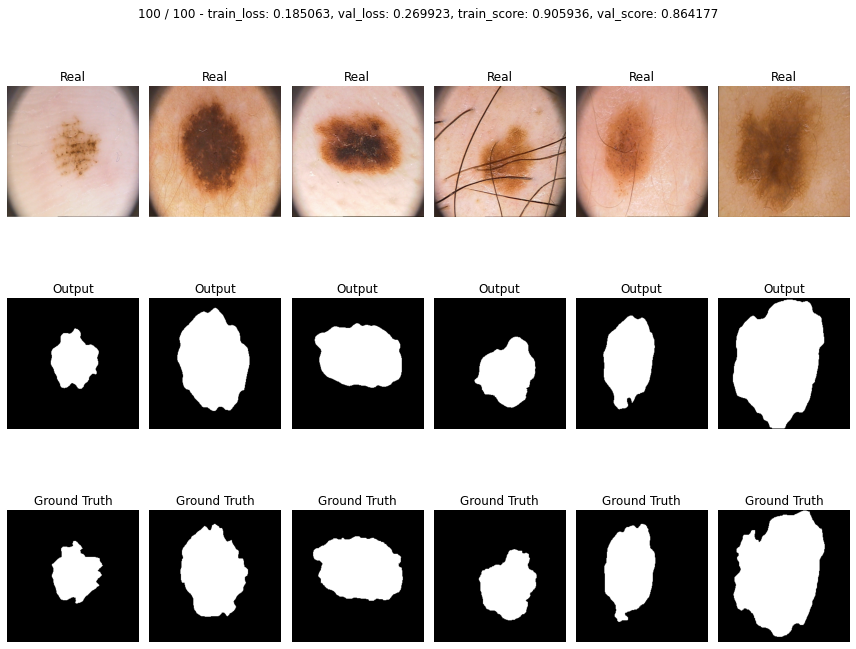

In [71]:
model_unet_lovasz = UNet(32).to(device)

max_epochs = 100
opt = optim.Adam(model_unet_lovasz.parameters(), lr=3e-4, amsgrad=True)
unet_lovasz = train(model_unet_lovasz, opt, lovasz_loss, max_epochs, data_tr, data_val, agm=True)

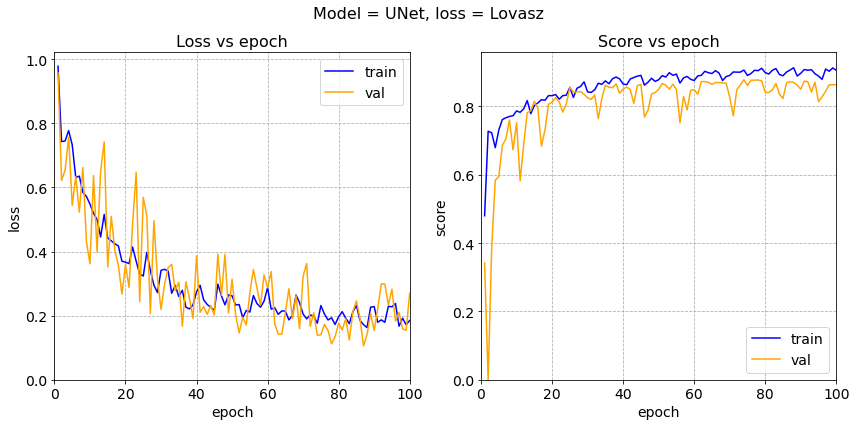

In [72]:
make_graph(unet_lovasz, "UNet", "Lovasz")

In [73]:
unet_lovasz_val_score, unet_lovasz_test_score = scores(model_unet_lovasz)

Score на валидации: 0.8785, score на тесте: 0.8750


In [74]:
# Очистка кеша
clear_cache(model_unet_lovasz)

In [75]:
# Сохраним результаты обучения
save_results(unet_lovasz, 'model_unet_lovasz')

## U-Net2

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [76]:
class UNet2(nn.Module):
    def __init__(self, inp_ch:int):
        super().__init__()
        """
        inp_ch - число фильтров в первом
        свёрточном слое
        """

        # Encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=inp_ch, kernel_size=3, padding=1),           
            nn.BatchNorm2d(inp_ch),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch, out_channels=inp_ch, kernel_size=3, padding=1),           
            nn.BatchNorm2d(inp_ch),
            nn.ReLU()
        )
        
        self.pool0 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch, out_channels=inp_ch, kernel_size=2, stride=2),
            nn.BatchNorm2d(inp_ch),
            nn.ReLU()
        )
    
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch, out_channels=inp_ch*2, kernel_size=3, padding=1),            
            nn.BatchNorm2d(inp_ch*2),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*2, out_channels=inp_ch*2, kernel_size=3, padding=1),            
            nn.BatchNorm2d(inp_ch*2),
            nn.ReLU()
        )
          
        self.pool1 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch*2, out_channels=inp_ch*2, kernel_size=2, stride=2),
            nn.BatchNorm2d(inp_ch*2),
            nn.ReLU()
        )
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch*2, out_channels=inp_ch*4, kernel_size=3, padding=1),            
            nn.BatchNorm2d(inp_ch*4),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*4, out_channels=inp_ch*4, kernel_size=3, padding=1),            
            nn.BatchNorm2d(inp_ch*4),
            nn.ReLU()
        )
        
        self.pool2 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch*4, out_channels=inp_ch*4, kernel_size=2, stride=2),
            nn.BatchNorm2d(inp_ch*4),
            nn.ReLU()
        )
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch*4, out_channels=inp_ch*8, kernel_size=3, padding=1),        
            nn.BatchNorm2d(inp_ch*8),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*8, out_channels=inp_ch*8, kernel_size=3, padding=1),           
            nn.BatchNorm2d(inp_ch*8),
            nn.ReLU()
        )
        
        self.pool3 = nn.Sequential(
        nn.Conv2d(in_channels=inp_ch*8, out_channels=inp_ch*8, kernel_size=2, stride=2),
        nn.BatchNorm2d(inp_ch*8),
        nn.ReLU()
        )    
          
        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch*8, out_channels=inp_ch*16, kernel_size=3, padding=1),           
            nn.BatchNorm2d(inp_ch*16),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*16, out_channels=inp_ch*8, kernel_size=3, padding=1),            
            nn.BatchNorm2d(inp_ch*8),
            nn.ReLU()
        )
        
        # Decoder (upsampling)
        self.upsample0 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=inp_ch*8, out_channels=inp_ch*8, kernel_size=2, stride=2),
            nn.BatchNorm2d(inp_ch*8),
            nn.ReLU()
        )
        
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch*16, out_channels=inp_ch*8, kernel_size=3, padding=1),            
            nn.BatchNorm2d(inp_ch*8),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*8, out_channels=inp_ch*4, kernel_size=3, padding=1),            
            nn.BatchNorm2d(inp_ch*4),
            nn.ReLU()
        )       
        
        self.upsample1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=inp_ch*4, out_channels=inp_ch*4, kernel_size=2, stride=2),
            nn.BatchNorm2d(inp_ch*4),
            nn.ReLU()
        )
        
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch*8, out_channels=inp_ch*4, kernel_size=3, padding=1),            
            nn.BatchNorm2d(inp_ch*4),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*4, out_channels=inp_ch*2, kernel_size=3, padding=1),           
            nn.BatchNorm2d(inp_ch*2),
            nn.ReLU()
        )
        
        self.upsample2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=inp_ch*2, out_channels=inp_ch*2, kernel_size=2, stride=2),
            nn.BatchNorm2d(inp_ch*2),
            nn.ReLU()
        )
        
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch*4, out_channels=inp_ch*2, kernel_size=3, padding=1),            
            nn.BatchNorm2d(inp_ch*2),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch*2, out_channels=inp_ch, kernel_size=3, padding=1),           
            nn.BatchNorm2d(inp_ch),
            nn.ReLU()
        )

        self.upsample3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=inp_ch, out_channels=inp_ch, kernel_size=2, stride=2),
            nn.BatchNorm2d(inp_ch),
            nn.ReLU()
        )
        
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch*2, out_channels=inp_ch, kernel_size=3, padding=1),            
            nn.BatchNorm2d(inp_ch),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch, out_channels=inp_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(inp_ch),
            nn.ReLU(),
            nn.Conv2d(in_channels=inp_ch, out_channels=1, kernel_size=1)
        )
        
        
        
    def forward(self, x):
        # Encoder
        e0 = self.enc_conv0(x)
        e1 = self.pool0(e0)
        e2 = self.enc_conv1(e1)
        e3 = self.pool1(e2)
        e4 = self.enc_conv2(e3)
        e5 = self.pool2(e4)
        e6 = self.enc_conv3(e5)
        e7 = self.pool3(e6)

        # Bottleneck
        b = self.bottleneck(e7)

        # Decoder
        d0 = self.upsample0(b)
        d0 = self.dec_conv0(torch.cat((d0,e6), dim=1))
        d1 = self.upsample1(d0)
        d1 = self.dec_conv1(torch.cat((d1,e4), dim=1))        
        d2 = self.upsample2(d1)
        d2 = self.dec_conv2(torch.cat((d2,e2), dim=1))           
        d3 = self.upsample3(d2)
        d3 = self.dec_conv3(torch.cat((d3,e0), dim=1)) # No activation  
        return d3    

In [77]:
summary(UNet2(32).to('cpu'), (1, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
UNet2                                    --                        --
├─Sequential: 1-1                        [1, 32, 256, 256]         --
│    └─Conv2d: 2-1                       [1, 32, 256, 256]         896
│    └─BatchNorm2d: 2-2                  [1, 32, 256, 256]         64
│    └─ReLU: 2-3                         [1, 32, 256, 256]         --
│    └─Conv2d: 2-4                       [1, 32, 256, 256]         9,248
│    └─BatchNorm2d: 2-5                  [1, 32, 256, 256]         64
│    └─ReLU: 2-6                         [1, 32, 256, 256]         --
├─Sequential: 1-2                        [1, 32, 128, 128]         --
│    └─Conv2d: 2-7                       [1, 32, 128, 128]         4,128
│    └─BatchNorm2d: 2-8                  [1, 32, 128, 128]         64
│    └─ReLU: 2-9                         [1, 32, 128, 128]         --
├─Sequential: 1-3                        [1, 64, 128, 128]         --
│    └─C

### 3.1 U-Net2 с BCE loss

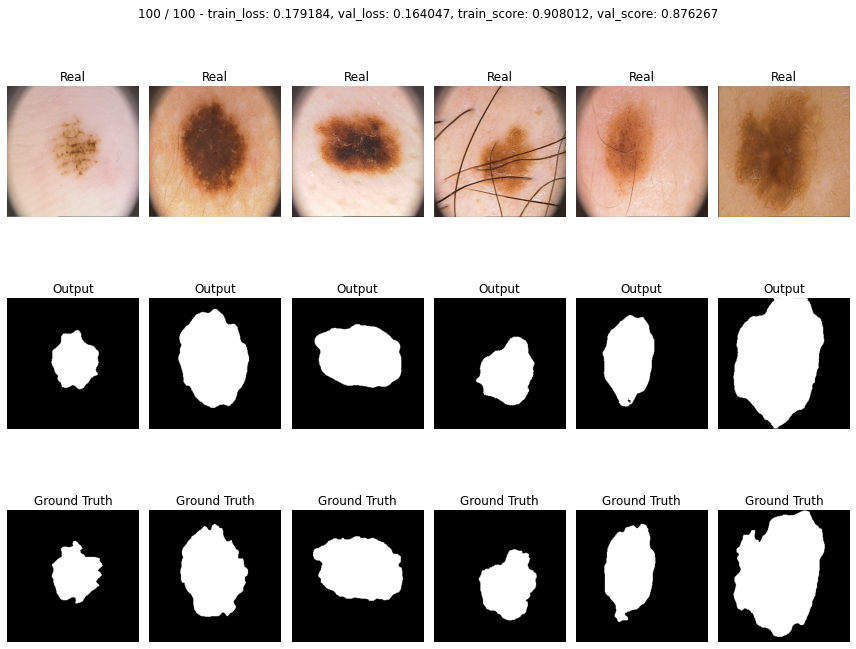

In [78]:
model_unet2_bce = UNet2(32).to(device)

max_epochs = 100
opt = optim.Adam(model_unet2_bce.parameters(), lr=3e-4, amsgrad=True)
unet2_bce = train(model_unet2_bce, opt, bce_loss, max_epochs, data_tr, data_val, agm=True)

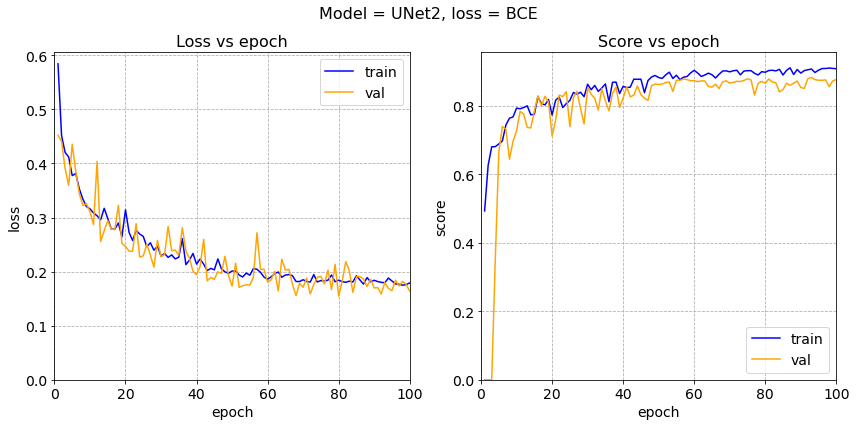

In [79]:
make_graph(unet2_bce, "UNet2", "BCE")

In [80]:
unet2_bce_val_score, unet2_bce_test_score = scores(model_unet2_bce)

Score на валидации: 0.8824, score на тесте: 0.8607


In [81]:
# Очистка кеша
clear_cache(model_unet2_bce)

In [82]:
# Сохраним результаты обучения
save_results(unet2_bce, 'model_unet2_bce')

### 3.2 U-Net2 с Dice loss

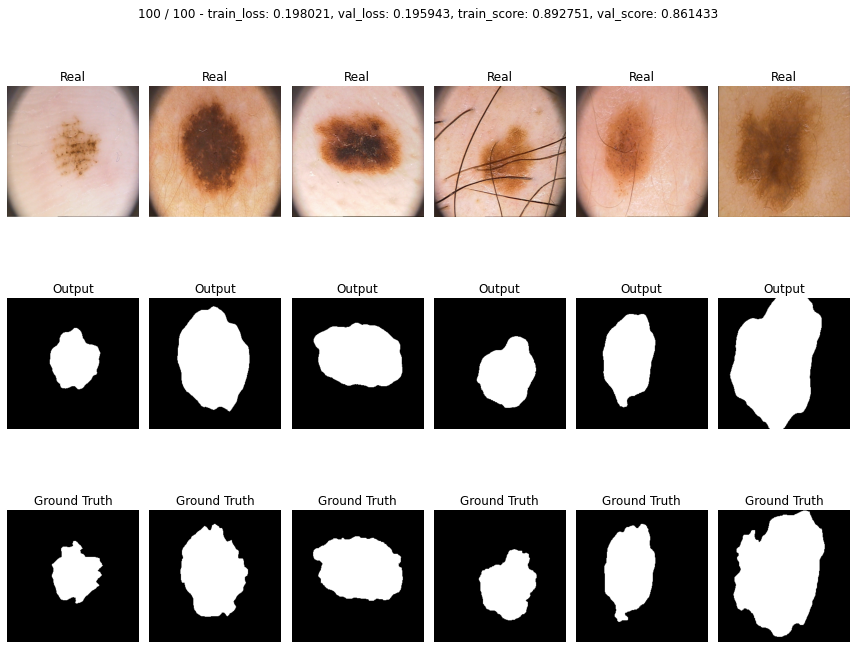

In [83]:
model_unet2_dice = UNet2(32).to(device)

max_epochs = 100
opt = optim.Adam(model_unet2_dice.parameters(), lr=3e-4, amsgrad=True)
unet2_dice = train(model_unet2_dice, opt, dice_loss, max_epochs, data_tr, data_val, agm=True)

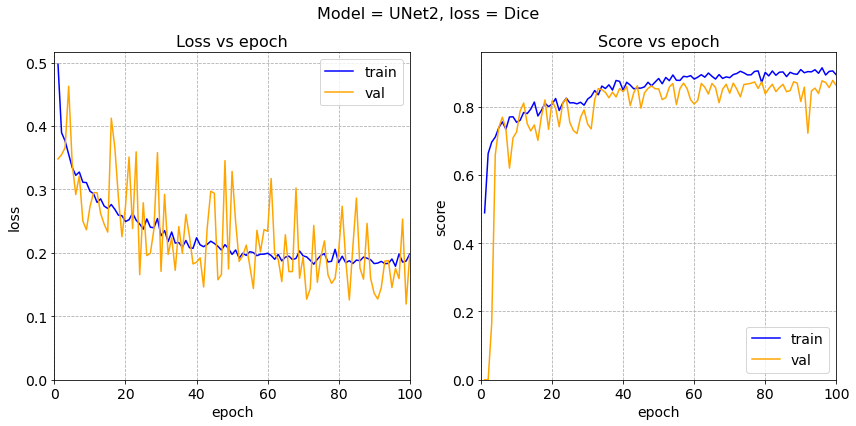

In [84]:
make_graph(unet2_dice, "UNet2", "Dice")

In [85]:
unet2_dice_val_score, unet2_dice_test_score = scores(model_unet2_dice)

Score на валидации: 0.8767, score на тесте: 0.8770


In [86]:
# Очистка кеша
clear_cache(model_unet2_dice)

In [87]:
# Сохраним результаты обучения
save_results(unet2_dice, 'model_unet2_dice')

### 3.3 U-Net2 с Focal loss

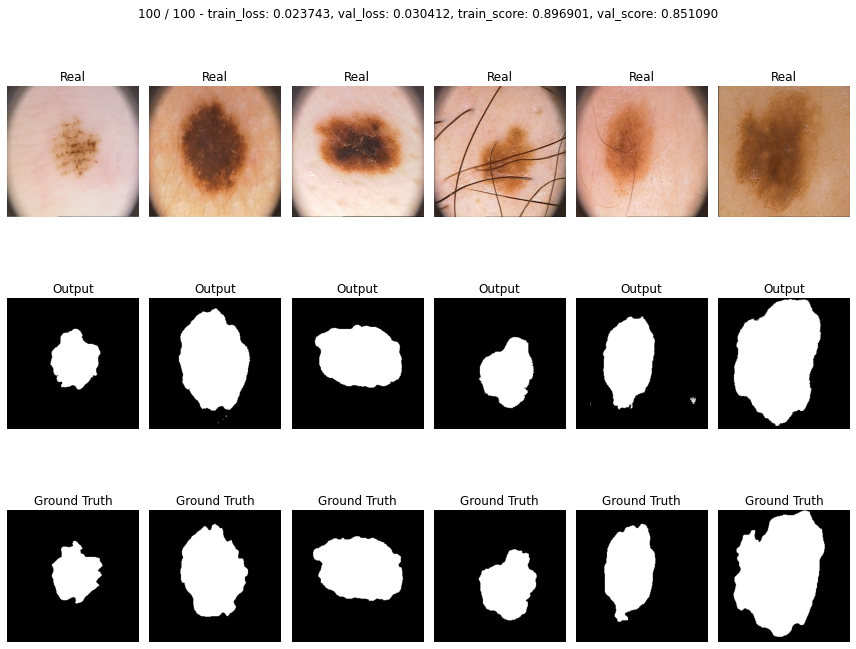

In [88]:
model_unet2_focal = UNet2(32).to(device)

max_epochs = 100
opt = optim.Adam(model_unet2_focal.parameters(), lr=3e-4, amsgrad=True)
unet2_focal = train(model_unet2_focal, opt, focal_loss, max_epochs, data_tr, data_val, agm=True)

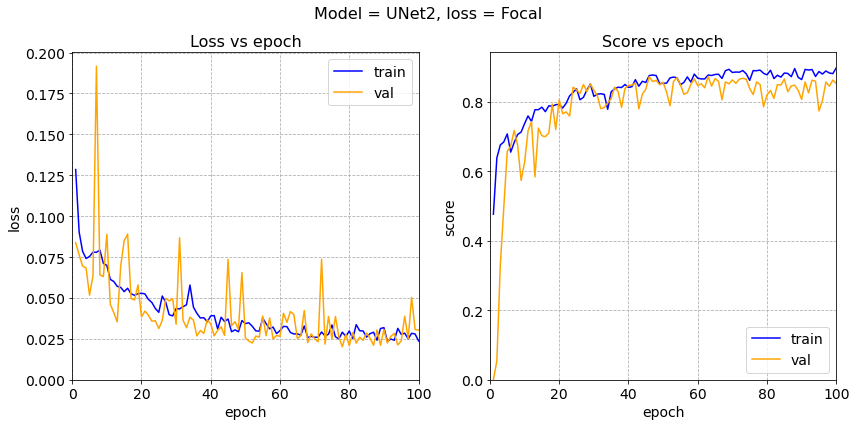

In [89]:
make_graph(unet2_focal, "UNet2", "Focal")

In [90]:
unet2_focal_val_score, unet2_focal_test_score = scores(model_unet2_focal)

Score на валидации: 0.8720, score на тесте: 0.8560


In [91]:
# Очистка кеша
clear_cache(model_unet2_focal)

In [92]:
# Сохраним результаты обучения
save_results(unet2_focal, 'model_unet2_focal')

### 3.4 U-Net2 с Lovasz Softmax loss

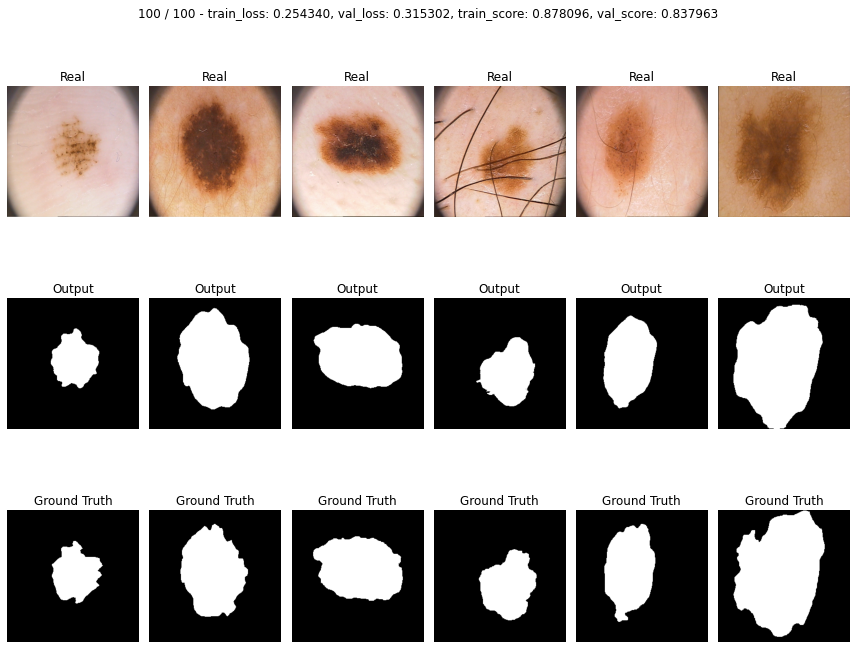

In [93]:
model_unet2_lovasz = UNet2(32).to(device)

max_epochs = 100
opt = optim.Adam(model_unet2_lovasz.parameters(), lr=3e-4, amsgrad=True)
unet2_lovasz = train(model_unet2_lovasz, opt, lovasz_loss, max_epochs, data_tr, data_val, agm=True)

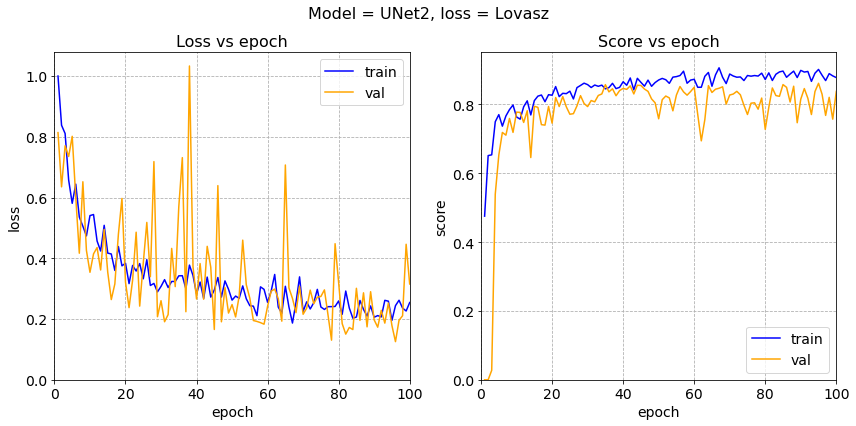

In [94]:
make_graph(unet2_lovasz, "UNet2", "Lovasz")

In [95]:
unet2_lovasz_val_score, unet2_lovasz_test_score = scores(model_unet2_lovasz)

Score на валидации: 0.8615, score на тесте: 0.8541


In [96]:
# Очистка кеша
clear_cache(model_unet2_lovasz)

In [97]:
# Сохраним результаты обучения
save_results(unet2_lovasz, 'model_unet2_lovasz')

Сделайте вывод, какая из моделей лучше

# Отчет: 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

### 4.1 Анализ графиков лоссов по эпохам

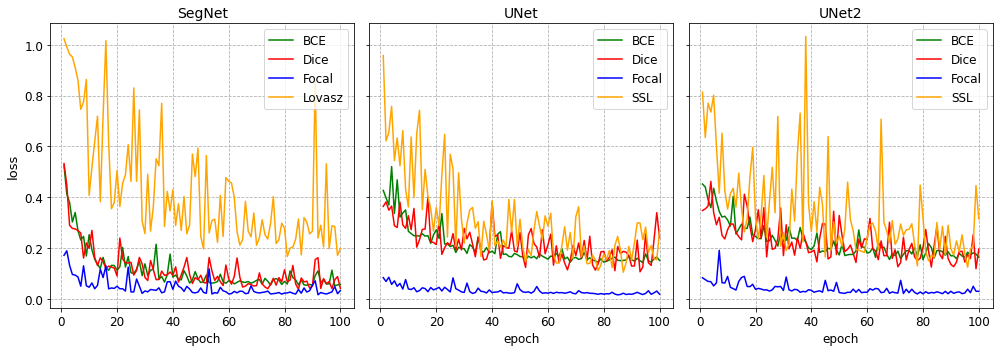

In [154]:
x = np.arange(100)+1
fig, ax = plt.subplots(1, 3, figsize=(14, 5), sharey=True)

y1 = segnet_bce["val"]["loss"]
y2 = segnet_dice["val"]["loss"]
y3 = segnet_focal["val"]["loss"]
y4 = segnet_lovasz["val"]["loss"]

ax[0].plot(x, y1, label="BCE", color="green")
ax[0].plot(x, y2, label="Dice", color="red")
ax[0].plot(x, y3, label="Focal", color="blue")
ax[0].plot(x, y4, label="Lovasz", color="orange")
ax[0].legend(fontsize=12)
ax[0].grid(linestyle="--")
ax[0].tick_params(labelsize=12)
ax[0].set_ylabel("loss", fontsize=13)
ax[0].set_title("SegNet", fontsize=14)
ax[0].set_xlabel("epoch", fontsize=12)


y1 = unet_bce["val"]["loss"]
y2 = unet_dice["val"]["loss"]
y3 = unet_focal["val"]["loss"]
y4 = unet_lovasz["val"]["loss"]

ax[1].plot(x, y1, label="BCE", color="green")
ax[1].plot(x, y2, label="Dice", color="red")
ax[1].plot(x, y3, label="Focal", color="blue")
ax[1].plot(x, y4, label="SSL", color="orange")
ax[1].legend(fontsize=12)
ax[1].grid(linestyle="--")
ax[1].tick_params(labelsize=12)
ax[1].set_title("UNet", fontsize=14)
ax[1].set_xlabel("epoch", fontsize=12)


y1 = unet2_bce["val"]["loss"]
y2 = unet2_dice["val"]["loss"]
y3 = unet2_focal["val"]["loss"]
y4 = unet2_lovasz["val"]["loss"]

ax[2].plot(x, y1, label="BCE", color="green")
ax[2].plot(x, y2, label="Dice", color="red")
ax[2].plot(x, y3, label="Focal", color="blue")
ax[2].plot(x, y4, label="SSL", color="orange")
ax[2].legend(fontsize=12)
ax[2].grid(linestyle="--")
ax[2].tick_params(labelsize=12)
ax[2].set_title("UNet2", fontsize=14)
ax[2].set_xlabel("epoch", fontsize=12)

plt.suptitle(f"Loss vs epoch (validation dataset)", fontsize=16, y=1.05)
plt.tight_layout()

Наибольшее стартовое значение и наибольшее значение после 100 эпох имеет Lovasz лосс. По асболютным значениям лоссы больше всего у модели UNet2, меньше всего - у модели UNet. Наименьшие значения во всех моделях показывает лосс Focal, наибольшие - Lovasz. Однако, наименьшее знечение лосса не явдяется показателем наибольшего значения скора. Это будет видно из дальнейших результатов работы.

### 4.2 Анализ графиков скора по эпохам в зависимости от модели

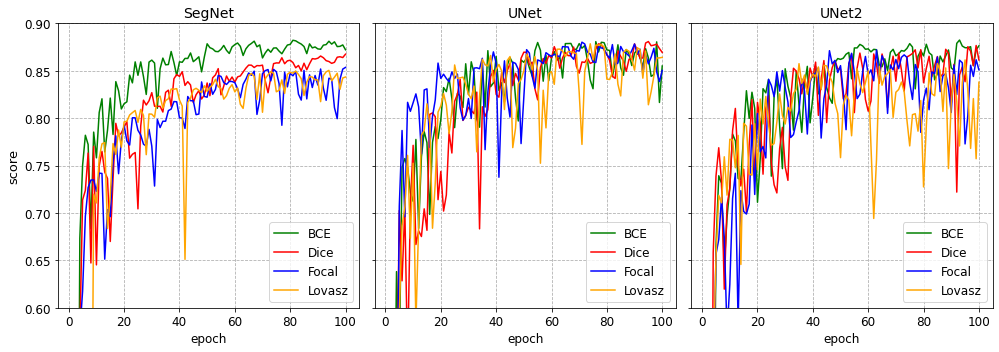

In [155]:
x = np.arange(100)+1
fig, ax = plt.subplots(1, 3, figsize=(14, 5), sharey=True)

y1 = segnet_bce["val"]["score"]
y2 = segnet_dice["val"]["score"]
y3 = segnet_focal["val"]["score"]
y4 = segnet_lovasz["val"]["score"]

ax[0].plot(x, y1, label="BCE", color="green")
ax[0].plot(x, y2, label="Dice", color="red")
ax[0].plot(x, y3, label="Focal", color="blue")
ax[0].plot(x, y4, label="Lovasz", color="orange")
ax[0].legend(fontsize=12)
ax[0].grid(linestyle="--")
ax[0].tick_params(labelsize=12)
ax[0].set_ylabel("score", fontsize=13)
ax[0].set_title("SegNet", fontsize=14)
ax[0].set_xlabel("epoch", fontsize=12)
ax[0].set_ylim(0.6, 0.9)


y1 = unet_bce["val"]["score"]
y2 = unet_dice["val"]["score"]
y3 = unet_focal["val"]["score"]
y4 = unet_lovasz["val"]["score"]

ax[1].plot(x, y1, label="BCE", color="green")
ax[1].plot(x, y2, label="Dice", color="red")
ax[1].plot(x, y3, label="Focal", color="blue")
ax[1].plot(x, y4, label="Lovasz", color="orange")
ax[1].legend(fontsize=12)
ax[1].grid(linestyle="--")
ax[1].tick_params(labelsize=12)
ax[1].set_title("UNet", fontsize=14)
ax[1].set_xlabel("epoch", fontsize=12)
ax[1].set_ylim(0.6, 0.9)


y1 = unet2_bce["val"]["score"]
y2 = unet2_dice["val"]["score"]
y3 = unet2_focal["val"]["score"]
y4 = unet2_lovasz["val"]["score"]

ax[2].plot(x, y1, label="BCE", color="green")
ax[2].plot(x, y2, label="Dice", color="red")
ax[2].plot(x, y3, label="Focal", color="blue")
ax[2].plot(x, y4, label="Lovasz", color="orange")
ax[2].legend(fontsize=12)
ax[2].grid(linestyle="--")
ax[2].tick_params(labelsize=12)
ax[2].set_title("UNet2", fontsize=14)
ax[2].set_xlabel("epoch", fontsize=12)
ax[2].set_ylim(0.6, 0.9)

plt.suptitle(f"Score vs epoch (validation dataset)", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

Из графиков видно, что максимальный скор по всем моделям находится примерно на одном уровне - около 0.88. И если у модели Segnet можно визуально определить как выбор лосс функции влияет на скор (лучший - BCE, худший - Focal), то для моделей семейства U-net все лосс функции обеспечивают примерно одинаковое качество. Кроме того стоит отметить, что максимальную стабильность показал лосс BCE, наименее стабильны лоссы Lovasz и Focal

### 4.3 Анализ графиков скора по эпохам в зависимости от лосса

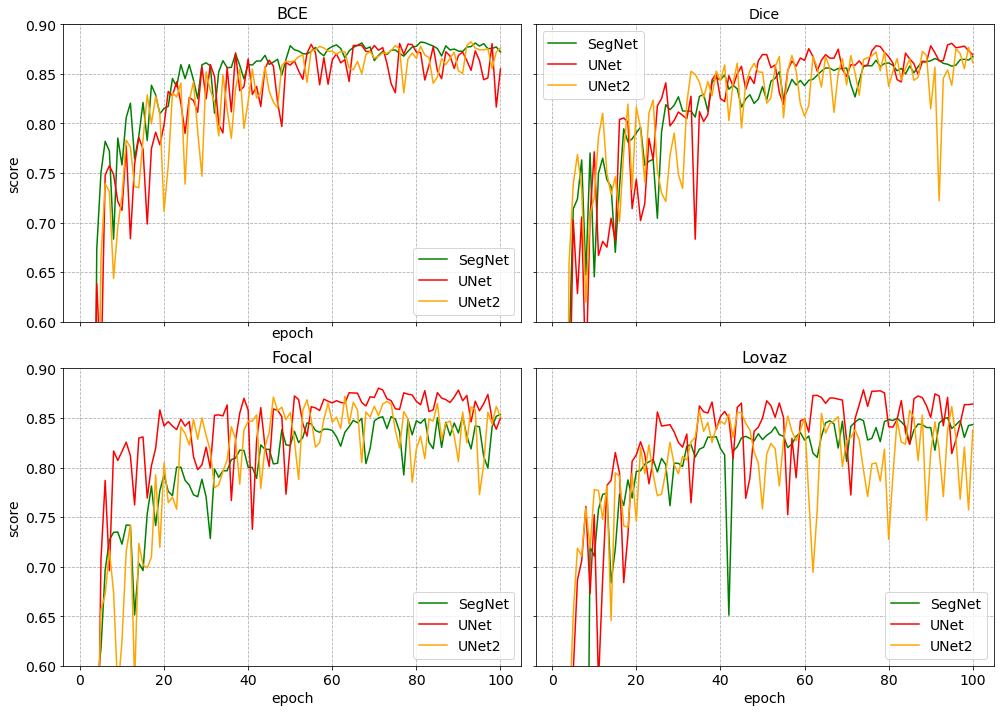

In [156]:
x = np.arange(100)+1
fig, ax = plt.subplots(2, 2, figsize=(14, 10), sharey=True, sharex=True)

y1 = segnet_bce["val"]["score"]
y2 = unet_bce["val"]["score"]
y3 = unet2_bce["val"]["score"]

ax[0, 0].plot(x, y1, label="SegNet", color="green")
ax[0, 0].plot(x, y2, label="UNet", color="red")
ax[0, 0].plot(x, y3, label="UNet2", color="orange")
ax[0, 0].legend(fontsize=14)
ax[0, 0].grid(linestyle="--")
ax[0, 0].tick_params(labelsize=14)
ax[0, 0].set_ylabel("score", fontsize=14)
ax[0, 0].set_title("BCE", fontsize=16)
ax[0, 0].set_xlabel("epoch", fontsize=14)
ax[0, 0].set_ylim(0.6, 0.9)


y1 = segnet_dice["val"]["score"]
y2 = unet_dice["val"]["score"]
y3 = unet2_dice["val"]["score"]

ax[0, 1].plot(x, y1, label="SegNet", color="green")
ax[0, 1].plot(x, y2, label="UNet", color="red")
ax[0, 1].plot(x, y3, label="UNet2", color="orange")
ax[0, 1].legend(fontsize=14)
ax[0, 1].grid(linestyle="--")
ax[0, 1].tick_params(labelsize=16)
ax[0, 1].set_title("Dice", fontsize=14)
ax[0, 1].set_ylim(0.6, 0.9)


y1 = segnet_focal["val"]["score"]
y2 = unet_focal["val"]["score"]
y3 = unet2_focal["val"]["score"]

ax[1, 0].plot(x, y1, label="SegNet", color="green")
ax[1, 0].plot(x, y2, label="UNet", color="red")
ax[1, 0].plot(x, y3, label="UNet2", color="orange")
ax[1, 0].legend(fontsize=14)
ax[1, 0].grid(linestyle="--")
ax[1, 0].tick_params(labelsize=14)
ax[1, 0].set_ylabel("score", fontsize=14)
ax[1, 0].set_title("Focal", fontsize=16)
ax[1, 0].set_xlabel("epoch", fontsize=14)
ax[1, 0].set_ylim(0.6, 0.9)


y1 = segnet_lovasz["val"]["score"]
y2 = unet_lovasz["val"]["score"]
y3 = unet2_lovasz["val"]["score"]

ax[1, 1].plot(x, y1, label="SegNet", color="green")
ax[1, 1].plot(x, y2, label="UNet", color="red")
ax[1, 1].plot(x, y3, label="UNet2", color="orange")
ax[1, 1].legend(fontsize=14)
ax[1, 1].grid(linestyle="--")
ax[1, 1].tick_params(labelsize=14)
ax[1, 1].set_title("Lovaz", fontsize=16)
ax[1, 1].set_xlabel("epoch", fontsize=14)
ax[1, 1].set_ylim(0.6, 0.9)

plt.suptitle(f"Score vs epoch (validation dataset)", fontsize=18, y=1.05)
plt.tight_layout()
plt.show()

Лосс BCE показал наибольшую точность на модели Segnet, как и наибольшую стабильность. Наименее стабилен Lovasz лосс.

### 4.4 Анализ скора на тестовом датасете

In [146]:
y = [segnet_bce_test_score, segnet_dice_test_score, segnet_focal_test_score, segnet_lovasz_test_score,
     unet_bce_test_score, unet_dice_test_score, unet_focal_test_score, unet_lovasz_test_score,
     unet2_bce_test_score, unet2_dice_test_score, unet2_focal_test_score, unet2_lovasz_test_score]

x = ['segnet_bce', 'segnet_dice', 'segnet_focal', 'segnet_lovasz',
     'unet_bce', 'unet_dice', 'unet_focal', 'unet_lovasz',
     'unet2_bce', 'unet2_dice', 'unet2_focal', 'unet2_lovasz']

colors = cm.get_cmap("viridis", 12).colors

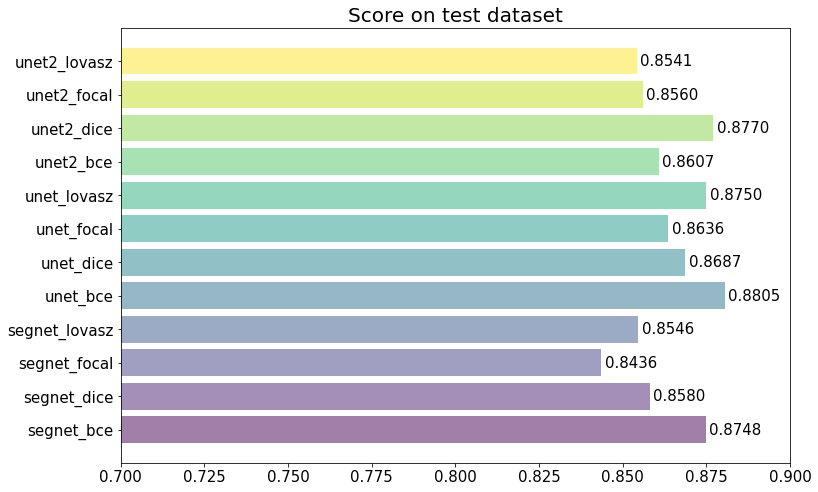

In [147]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(x, y, color=colors, alpha=0.5)
ax.set_xlim(0.7, 0.9)
ax.tick_params(labelsize=15)
for i in range(12):
    ax.text(y[i]+0.001, i - 0.15, f"{y[i]:.4f}", fontsize=15)
    ax.grid(linestyle="--")
ax.set_title("Score on test dataset", fontsize=20)
plt.show()

На тестовом датасете лидером оказалась модель U-Net с лоссом BCE, на втором месте U-Net2 с лоссом Dice и замыкает тройку SegNet с лоссом BCE. Можно сделать вывод, что архитектура U-Net в целом показывает лучшее качество пр сравнению с SegNet, во многом благодаря skip-connections. Лоссом-лидером в данном случае оказался BCE. Модель аутсайдер - Segnet с лоссом Focal.

### 4.5 Заключение и общие выводы

По итогам работы можно сделать вывод, что лучшей моделью для данной задачи является UNet. Однако, отставание UNet2 совсем небольшое. Что касается лоссов, то ожидалось, что каждый лосс будет стабильно хуже или лучше другого вне зависимости от модели, но в реализации оказалось, что они практически идентичны с точки зрения финального скора и на лидерство в большей степени влияет разделение датасета, его качество и начальная инициализация весов модели. В моём случае это подтверждено на практике, так как после нескольких прогонов блокнота в лидерах побывала практически каждая лосс функция, за исключением разве что Focal лосс. Но Focal лосс является довольно специфическим и предназначен для тех случаев, когда классы довольно сильно не сбалансированны, как пример - сегментация мелких фрагментов тканей на крупных снимках. Но даже он в одном из прогонов попал на второе место, что в целом  говорит об общей нетребовательности данного датасета к лосс функциям. Возможно, для больше уточнения, нужно выполнить около десятка прогонов и усреднить результат, но в связи с жётским дедлайном эта идея останется за рамками данной работы и перейдёт в категорию, - что можно сделать в будущем. Также к не выполненным идеям можно отнести реализацию аугментации не по-батчево, а по изображениям. Тем не менее, даже такая реализация, когда аугментация применяется не к отдельному изображению, а к целому батчу, показала значительное снижение переобучения и повышение итогового скора модели. Все модели показали хорошую точность с числом фильтров в первом свёрточном слое равном 32, увеличение фильтров до 64 практически никак не увеличивает точность, но значительно повышает затраты памяти GPU и время обучение моделей. В заключение могу сказать, что лидером после нескольких прогонов данного блокнота стала модель U-Net с лоссом BCE. Модель U-Net практически всегда обеспечивала высокий скор и была наименее склонна к переобучению, а BCE лосс оставался максимально стабильным на всех моделях.